# Argriculture Price and Spread Analysis

The data used in this analysis was pulled from kaggle.com (https://www.kaggle.com/datasets/everydaycodings/produce-prices-dataset).

It contains data on 22 different fruits and vegetables with the following fields:
<ul>
    <li>Product Name: Name of the produce item.</li>
    <li>Date: The date of the pricing information.</li>
    <li>Farm Price: The price at which the produce is sold at the farm.</li>
    <li>Retail Prices: Retail prices in major cities (Atlanta, Chicago, Los Angeles, New York).</li>
    <li>Average Spread: Percentage indicating the average markup between farm and retail prices.</li>
</ul>

In [1]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

import plotly
import cufflinks as cf
cf.go_offline()

## Data Exploration, Cleanup, and Additions
<ol>
    <li>Pull in data and explore content, features, and data types using pandas</li>
    <li>Update column data types</li>
    <li>Drop unwanted rows</li>
    <li>Add additional columns and reorder</li>
    <li>Investigate outliers</li>
</ol>

In [3]:
# Pull in and view dataset
prod_price_df = pd.read_csv('Data/ProductPriceIndex.csv')
prod_price_df.head()

,productname,date,farmprice,atlantaretail,chicagoretail,losangelesretail,newyorkretail,averagespread
0,Strawberries,2019-05-19,$1.16,$2.23,$1.70,$1.99,$2.54,82.33%
1,Romaine Lettuce,2019-05-19,$0.35,$1.72,$2.00,$1.69,$1.99,428.57%
2,Red Leaf Lettuce,2019-05-19,$0.32,$1.84,$1.84,$1.69,$1.89,467.19%
3,Potatoes,2019-05-19,$1.50,$5.32,$5.14,$3.99,$6.22,244.50%
4,Oranges,2019-05-19,$0.41,$1.42,$1.45,$1.34,$2.05,281.71%


In [4]:
# See more info on size and datatypes
prod_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15766 entries, 0 to 15765
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   productname       15766 non-null  object
 1   date              15766 non-null  object
 2   farmprice         15766 non-null  object
 3   atlantaretail     15766 non-null  object
 4   chicagoretail     15766 non-null  object
 5   losangelesretail  15766 non-null  object
 6   newyorkretail     15766 non-null  object
 7   averagespread     15766 non-null  object
dtypes: object(8)
memory usage: 985.5+ KB


In [5]:
# Update column names
prod_price_df = prod_price_df.rename(columns={'productname':'product_name',
                                      'farmprice':'farm_price',
                                      'atlantaretail':'atl_price',
                                      'chicagoretail':'chi_price',
                                      'losangelesretail':'la_price',
                                      'newyorkretail':'ny_price',
                                      'averagespread':'avg_spread'})
prod_price_df.head()

,product_name,date,farm_price,atl_price,chi_price,la_price,ny_price,avg_spread
0,Strawberries,2019-05-19,$1.16,$2.23,$1.70,$1.99,$2.54,82.33%
1,Romaine Lettuce,2019-05-19,$0.35,$1.72,$2.00,$1.69,$1.99,428.57%
2,Red Leaf Lettuce,2019-05-19,$0.32,$1.84,$1.84,$1.69,$1.89,467.19%
3,Potatoes,2019-05-19,$1.50,$5.32,$5.14,$3.99,$6.22,244.50%
4,Oranges,2019-05-19,$0.41,$1.42,$1.45,$1.34,$2.05,281.71%


### Update column data types
prod_price_df.info() showed us that all the columns are string data types (denoted 'object' in pandas). In order to do analysis on the date and numeric columns we need to update the columns to the approriate datatype of datetime or float. 

In [6]:
# Update 'date'
prod_price_df['date'] = pd.to_datetime(prod_price_df['date'], yearfirst=True)

In [7]:
# Update price columns (convert values of '$' to NaN)
price_cols = ['farm_price', 'atl_price', 'chi_price','la_price', 'ny_price']

for col in price_cols:
    # split the column by '$'
    str_float = prod_price_df[col].str.split('$', expand=True)[1]
    # if no number attached to the '$', mark NaN
    str_float[str_float == ''] = np.nan
    # convert the column to float dtype
    prod_price_df[col] = str_float.astype(float)

In [8]:
# Update 'avg_spread'

# split the column by '%'
str_percent = prod_price_df['avg_spread'].str.split('%', expand=True)[0]
# remove commas
str_percent = str_percent.str.replace(',', '')
# convert to float and round to 2
prod_price_df['avg_spread'] = str_percent.astype(float).round(2)

In [9]:
# View Dtypes to confirm columns are correct types
prod_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15766 entries, 0 to 15765
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   product_name  15766 non-null  object        
 1   date          15766 non-null  datetime64[ns]
 2   farm_price    15765 non-null  float64       
 3   atl_price     15765 non-null  float64       
 4   chi_price     15766 non-null  float64       
 5   la_price      15766 non-null  float64       
 6   ny_price      15758 non-null  float64       
 7   avg_spread    15766 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 985.5+ KB


### Remove unwanted rows
The data set contains nearly 16,000 rows, which is plenty of data, so for continuity and ease of analysis we will drop the entire row that contains NaN.

We will also drop any row that contains a price  of $0.00, as we can assume that is incorrect data and does not represent the real price of a product.

In [10]:
# View all rows with NaN values
prod_price_df[prod_price_df.isna().any(axis=1)]

,product_name,date,farm_price,atl_price,chi_price,la_price,ny_price,avg_spread
107,Romaine Lettuce,2019-03-24,0.34,1.99,2.12,1.69,NaN,326.47
234,Red Leaf Lettuce,2019-01-13,0.66,2.32,1.98,1.74,NaN,128.79
262,Iceberg Lettuce,2018-12-30,0.47,1.29,1.54,1.67,NaN,139.36
315,Thompson Grapes,2018-12-02,0.85,2.31,1.64,2.12,NaN,78.53
331,Strawberries,2018-11-25,2.69,3.36,3.84,3.99,NaN,4.00
466,Romaine Lettuce,2018-09-23,0.44,1.59,1.99,1.42,NaN,184.09
690,Red Leaf Lettuce,2018-07-01,0.31,1.62,1.71,1.42,NaN,283.06
1261,Broccoli Crowns,2017-09-24,1.71,2.10,1.32,1.94,NaN,-21.64
2469,Celery,2016-02-28,0.53,NaN,1.92,1.99,1.72,165.57
2590,Oranges,2015-12-20,NaN,1.89,1.27,0.99,1.65,0.00


In [11]:
# Drop all 10 rows with NaN values and reset index
prod_price_df = prod_price_df.dropna().reset_index(drop=True)
prod_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15756 entries, 0 to 15755
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   product_name  15756 non-null  object        
 1   date          15756 non-null  datetime64[ns]
 2   farm_price    15756 non-null  float64       
 3   atl_price     15756 non-null  float64       
 4   chi_price     15756 non-null  float64       
 5   la_price      15756 non-null  float64       
 6   ny_price      15756 non-null  float64       
 7   avg_spread    15756 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 984.9+ KB


In [16]:
# Investigate how widespread $0.00 is in dataset

# Create a list of cities to iterate through 
price_cols = ['farm', 'atl', 'chi', 'la', 'ny']

# Determine how many are present per city and over what time period
for col in price_cols:
    zero_df = prod_price_df[prod_price_df[f'{col}_price'] == 0.0]
    print(f'{col}_price contains {len(zero_df)} 0.0 values.')
    print(f'They range from {zero_df["date"].min()} to {zero_df["date"].max()}.')
    print('-'*20)

farm_price contains 11 0.0 values.
They range from 2002-09-29 00:00:00 to 2014-08-17 00:00:00.
--------------------
atl_price contains 193 0.0 values.
They range from 2001-03-25 00:00:00 to 2015-09-20 00:00:00.
--------------------
chi_price contains 1103 0.0 values.
They range from 1999-10-24 00:00:00 to 2014-08-17 00:00:00.
--------------------
la_price contains 84 0.0 values.
They range from 2001-10-21 00:00:00 to 2016-01-31 00:00:00.
--------------------
ny_price contains 332 0.0 values.
They range from 2000-04-09 00:00:00 to 2016-02-28 00:00:00.
--------------------


In [18]:
# Drop all rows containing a $0.00 price

for col in price_cols:
    prod_price_df = prod_price_df[prod_price_df[f'{col}_price'] != 0.0]
    
prod_price_df = prod_price_df.reset_index(drop=True)
prod_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14191 entries, 0 to 14190
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   product_name  14191 non-null  object        
 1   date          14191 non-null  datetime64[ns]
 2   farm_price    14191 non-null  float64       
 3   atl_price     14191 non-null  float64       
 4   chi_price     14191 non-null  float64       
 5   la_price      14191 non-null  float64       
 6   ny_price      14191 non-null  float64       
 7   avg_spread    14191 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 887.1+ KB


### Add spread columns by city
Using the farm price and the city price, we can calculate each city's spread on a given product on a given day.
Remember, all spreads are percentage values.

In [20]:
# Add a spread column for each city
cities = ['atl', 'chi', 'la', 'ny']

for city in cities:
    # Create new column for city spread
    prod_price_df[f'{city}_spread'] = \
    ((prod_price_df[f'{city}_price'] - prod_price_df['farm_price']) / prod_price_df['farm_price']) * 100
    
    # Round to two decimal places
    prod_price_df[f'{city}_spread'] = prod_price_df[f'{city}_spread'].round(2)
    
prod_price_df.head()

,product_name,date,farm_price,atl_price,chi_price,la_price,ny_price,avg_spread,atl_spread,chi_spread,la_spread,ny_spread
0,Strawberries,2019-05-19,1.16,2.23,1.70,1.99,2.54,82.33,92.24,46.55,71.55,118.97
1,Romaine Lettuce,2019-05-19,0.35,1.72,2.00,1.69,1.99,428.57,391.43,471.43,382.86,468.57
2,Red Leaf Lettuce,2019-05-19,0.32,1.84,1.84,1.69,1.89,467.19,475.00,475.00,428.12,490.62
3,Potatoes,2019-05-19,1.50,5.32,5.14,3.99,6.22,244.50,254.67,242.67,166.00,314.67
4,Oranges,2019-05-19,0.41,1.42,1.45,1.34,2.05,281.71,246.34,253.66,226.83,400.00


In [21]:
# Reorder columns and sort by date and product type to assist with plotting
ordered_cols = ['date','product_name','farm_price','atl_price','chi_price','la_price',
                'ny_price','atl_spread','chi_spread','la_spread','ny_spread','avg_spread']
prod_price_df = prod_price_df[ordered_cols] \
    .sort_values(by=['date', 'product_name'], ascending=True).reset_index(drop=True)

In [22]:
prod_price_df.head(20)

,date,product_name,farm_price,atl_price,chi_price,la_price,ny_price,atl_spread,chi_spread,la_spread,ny_spread,avg_spread
0,2001-02-04,Avocados,0.58,1.09,1.52,1.69,1.70,87.93,162.07,191.38,193.10,158.62
1,2001-02-04,Broccoli Bunches,0.25,1.23,1.19,1.07,1.14,392.00,376.00,328.00,356.00,363.00
2,2001-02-04,Broccoli Crowns,0.32,1.59,1.29,1.46,1.14,396.88,303.12,356.25,256.25,328.13
3,2001-02-04,Carrots,0.17,0.71,0.77,0.39,0.77,317.65,352.94,129.41,352.94,288.24
4,2001-02-04,Cauliflower,0.25,1.02,0.88,1.14,0.93,308.00,252.00,356.00,272.00,297.00
5,2001-02-04,Celery,0.28,1.47,1.27,1.07,1.27,425.00,353.57,282.14,353.57,353.57
6,2001-02-04,Green Leaf Lettuce,0.18,1.24,1.52,1.07,1.87,588.89,744.44,494.44,938.89,691.67
7,2001-02-04,Iceberg Lettuce,0.40,1.26,0.99,0.99,1.39,215.00,147.50,147.50,247.50,189.38
8,2001-02-04,Potatoes,0.65,3.24,3.29,2.47,3.49,398.46,406.15,280.00,436.92,380.38
9,2001-02-04,Red Leaf Lettuce,0.21,1.24,1.52,1.02,1.87,490.48,623.81,385.71,790.48,572.62


### Investigate Outliers
A boxplot can help us investigate outliers and determine if any need to be dropped. The analysis below reveals only one truly troubling outlier that we will remove

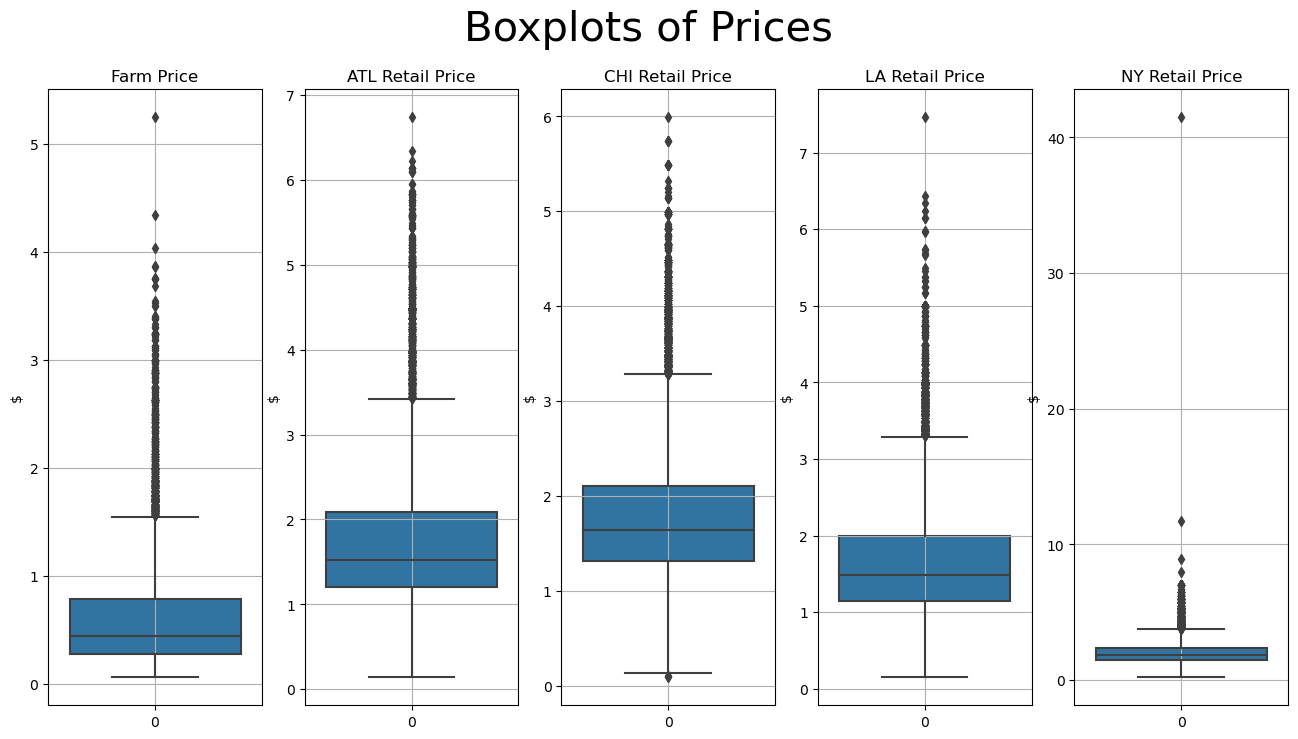

In [23]:
# Box plots to visualize
fig, ax = plt.subplots(1, 5, sharey=False, figsize=(16,8))
fig.suptitle('Boxplots of Prices', fontsize=30)

sns.boxplot(prod_price_df['farm_price'],ax=ax[0])
ax[0].set_title('Farm Price')
ax[0].set_ylabel("$")
ax[0].grid()

for city in cities:
    axis=ax[cities.index(city)+1]
    sns.boxplot(prod_price_df[f'{city}_price'], ax=axis)
    axis.set_title(f'{city.upper()} Retail Price')
    axis.set_ylabel("$")
    axis.grid()

In [24]:
# Based on the above, there is only one concerning outlier in the 40s for 'ny_price' that we will remove.

# View the outlier row
print(prod_price_df[prod_price_df['ny_price'] == prod_price_df['ny_price'].max()][['product_name', 'date', 'ny_price', 'atl_price', 'la_price', 'chi_price']])

# Save the index and drop the row
drop_index = prod_price_df[prod_price_df['ny_price'] == prod_price_df['ny_price'].max()].index[0]

prod_price_df = prod_price_df.drop(drop_index).reset_index(drop=True)

          product_name       date  ny_price  atl_price  la_price  chi_price
2678  Red Leaf Lettuce 2004-06-20     41.49       1.09       0.8       1.27


<b>Our dataframe is now clean so we will rename it 'df' for ease of during analysis</b>

In [25]:
df = prod_price_df
df.head()

,date,product_name,farm_price,atl_price,chi_price,la_price,ny_price,atl_spread,chi_spread,la_spread,ny_spread,avg_spread
0,2001-02-04,Avocados,0.58,1.09,1.52,1.69,1.70,87.93,162.07,191.38,193.10,158.62
1,2001-02-04,Broccoli Bunches,0.25,1.23,1.19,1.07,1.14,392.00,376.00,328.00,356.00,363.00
2,2001-02-04,Broccoli Crowns,0.32,1.59,1.29,1.46,1.14,396.88,303.12,356.25,256.25,328.13
3,2001-02-04,Carrots,0.17,0.71,0.77,0.39,0.77,317.65,352.94,129.41,352.94,288.24
4,2001-02-04,Cauliflower,0.25,1.02,0.88,1.14,0.93,308.00,252.00,356.00,272.00,297.00


## Further Exploration
Now that our data is clean, we can do a deeper dive to better understand the data

In [26]:
# the describe() function gives a good overview of all numeric columns
df.describe()

,farm_price,atl_price,chi_price,la_price,ny_price,atl_spread,chi_spread,la_spread,ny_spread,avg_spread
count,14190.000000,14190.000000,14190.000000,14190.000000,14190.000000,14190.000000,14190.000000,14190.000000,14190.000000,14190.000000
mean,0.603426,1.767135,1.821047,1.741467,2.062648,280.560364,304.798953,269.482102,345.963319,300.201313
std,0.484413,0.909299,0.845178,0.904817,1.052747,202.448611,238.446939,204.949371,248.078770,211.394758
min,0.060000,0.140000,0.090000,0.150000,0.200000,-47.590000,-48.330000,-62.070000,-80.950000,-39.580000
25%,0.280000,1.200000,1.310000,1.140000,1.450000,140.325000,144.440000,138.472500,177.050000,155.777500
50%,0.440000,1.520000,1.640000,1.490000,1.840000,242.310000,247.560000,227.270000,300.000000,254.630000
75%,0.790000,2.090000,2.100000,2.000000,2.370000,383.330000,400.000000,359.060000,447.060000,400.000000
max,5.250000,6.740000,5.990000,7.460000,11.740000,3015.380000,3372.730000,2880.000000,3527.270000,2963.640000


In [27]:
# View frequency of products in the dataset
print(f"Number of unique products in dataset: {df['product_name'].nunique()}")

df['product_name'].value_counts()

Number of unique products in dataset: 22


Cauliflower           947
Iceberg Lettuce       945
Green Leaf Lettuce    944
Celery                943
Red Leaf Lettuce      943
Romaine Lettuce       943
Broccoli Crowns       939
Carrots               939
Strawberries          915
Broccoli Bunches      902
Oranges               722
Avocados              654
Potatoes              610
Flame Grapes          473
Cantaloupe            466
Honeydews             426
Tomatoes              334
Thompson Grapes       261
Asparagus             235
Nectarines            228
Peaches               226
Plums                 195
Name: product_name, dtype: int64

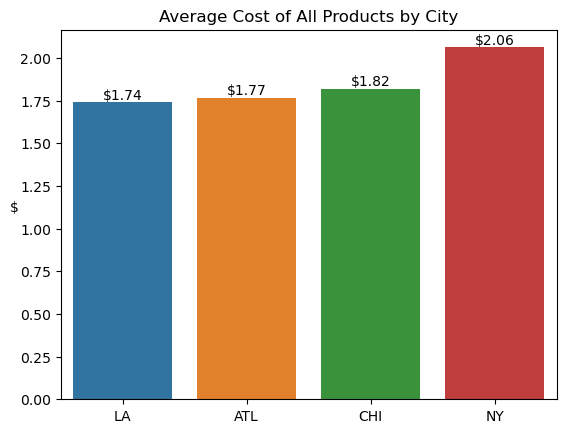

In [28]:
# Most expensive cities for consumers
city_price_avg = df[['atl_price', 'chi_price', 'la_price', 'ny_price']].mean().sort_values()

ax = sns.barplot(x=['LA','ATL','CHI', 'NY'], y=city_price_avg)
ax.bar_label(ax.containers[0], fmt='$%.2f')
plt.ylabel('$', rotation=0)
plt.title('Average Cost of All Products by City')
plt.show()

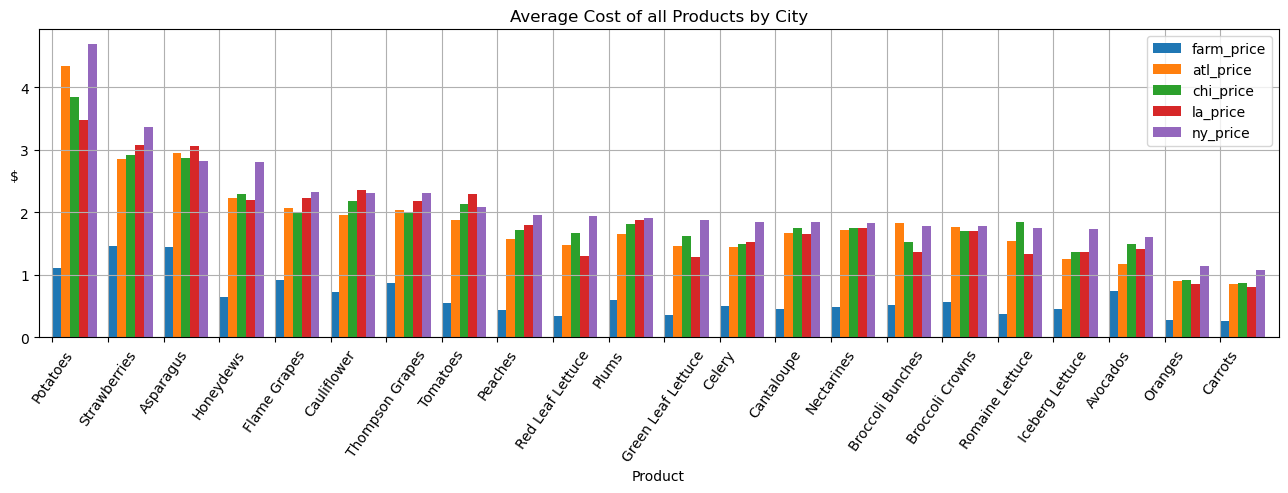

In [29]:
# Now let's see which product is most expensive for distributors and for consumers

product_groupby = df.groupby('product_name')
product_groupby.mean()[['farm_price','atl_price','chi_price','la_price','ny_price']] \
    .sort_values('ny_price', ascending=False).plot(kind='bar', figsize=(16,4), width=0.8, position=0)
plt.legend(loc='upper right')
plt.ylabel('$', rotation=0)
plt.grid()
plt.xlabel('Product')
plt.title('Average Cost of all Products by City')
plt.tick_params(axis='x', rotation=55)
plt.show()

In [30]:
# More interactive view with plotly (hover over bars to see values)
product_groupby.mean()[['farm_price','atl_price','chi_price','la_price','ny_price']] \
    .sort_values('ny_price', ascending=False).iplot(kind='bar')

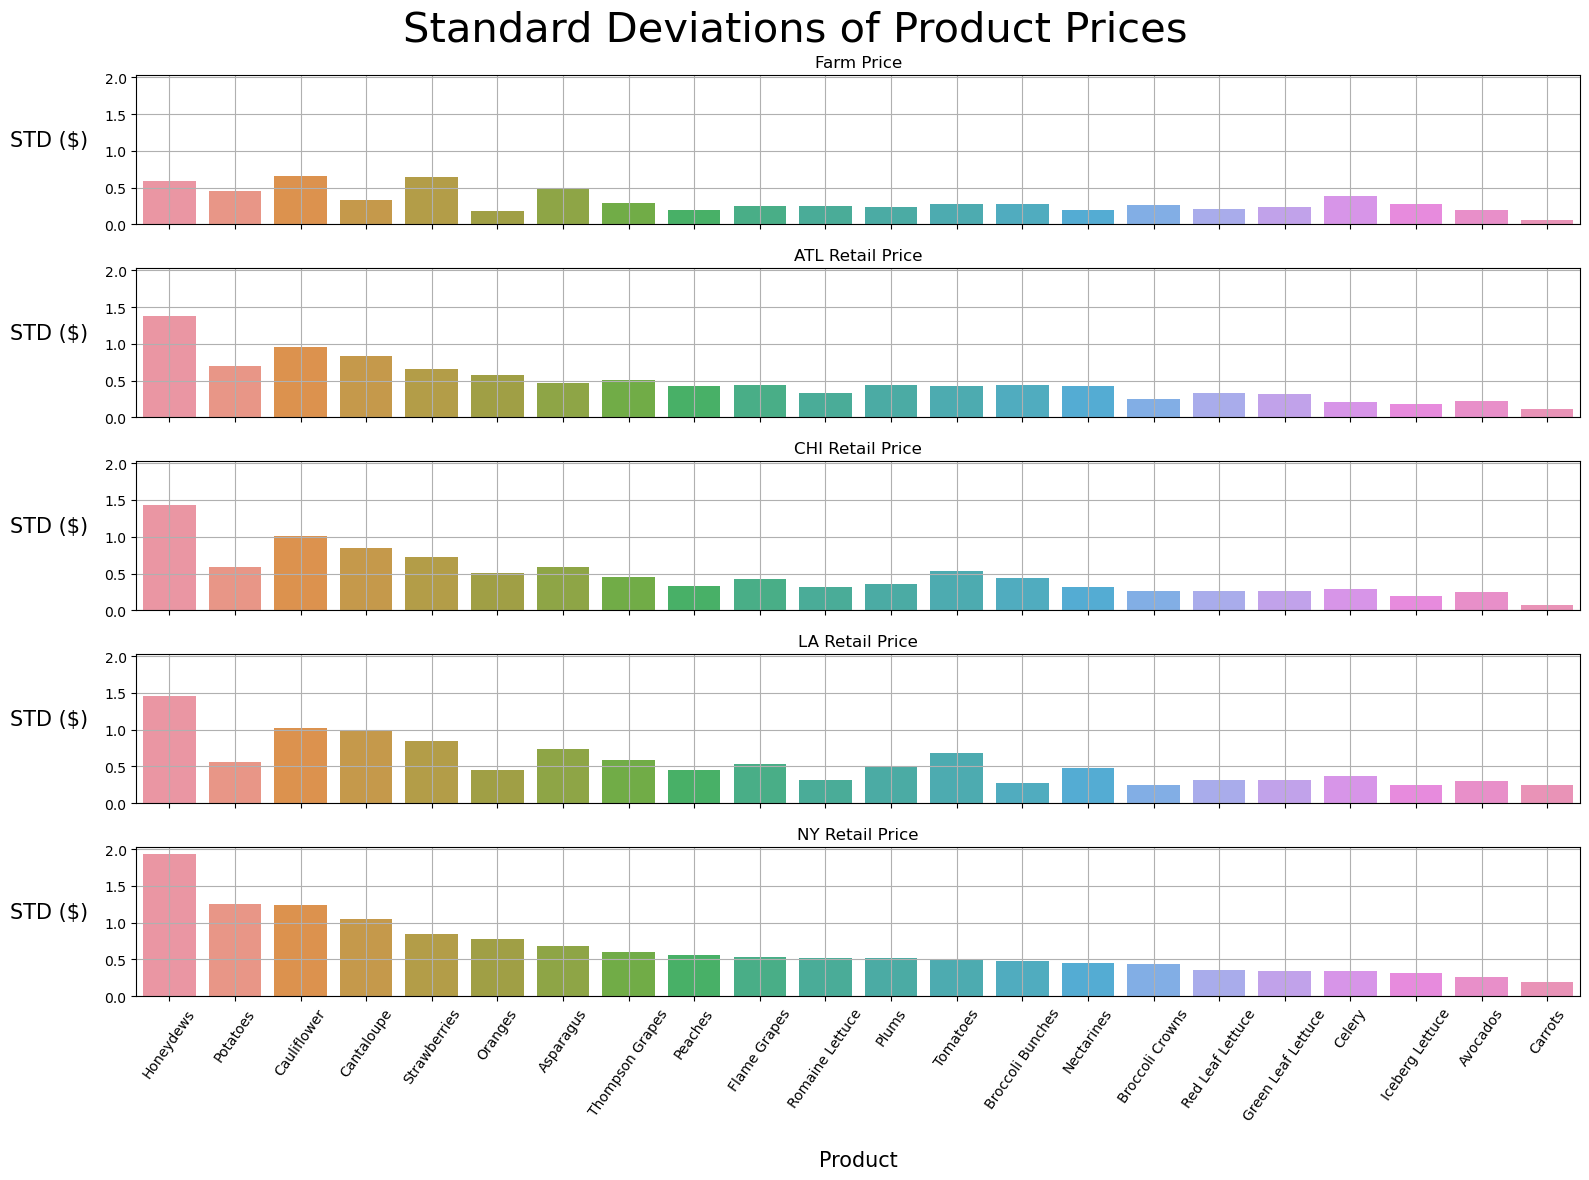

In [31]:
# Look at which products have the largest variation in price by looking at the standard deviation 
product_std = product_groupby.std().reset_index().sort_values('ny_price', ascending=False)

fig, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(16,12))
fig.suptitle('Standard Deviations of Product Prices', fontsize=30)

sns.barplot(ax=ax[0], x='product_name', y='farm_price', data=product_std)
ax[0].set_title('Farm Price')
ax[0].set_xlabel("")
ax[0].set_ylabel("STD ($)", rotation=0, labelpad=40, fontsize=15)
ax[0].grid()


for city in cities:
    axis=ax[cities.index(city)+1]
    sns.barplot(ax=axis,x='product_name', y=f'{city}_price', data=product_std)
    axis.set_title(f'{city.upper()} Retail Price')
    axis.set_xlabel("")
    axis.set_ylabel("STD ($)", rotation=0, labelpad=40, fontsize=15)
    axis.grid()
    axis.label_outer()


ax[4].set_xlabel("Product", labelpad=20, fontsize=15)
ax[4].tick_params(axis='x', rotation=55)
fig.tight_layout()

plt.show()

## Spread Analysis
Now we'll dive into the spread data and determine which products are marked the most from farm to table

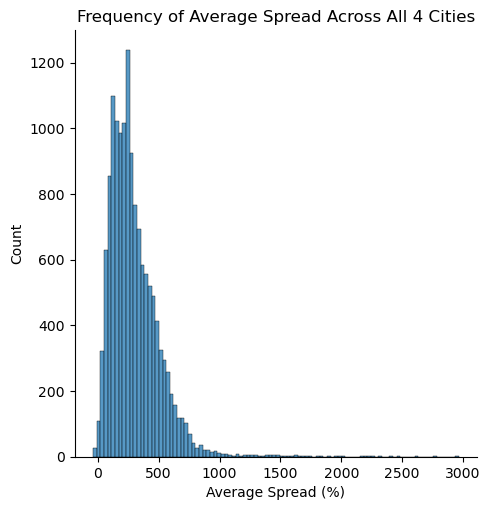

The mean of all average spread values across the four cities is: 300.2013128964049%


In [34]:
# MARGIN ANALYSIS
sns.displot(df['avg_spread'], bins=100)
plt.title("Frequency of Average Spread Across All 4 Cities")
plt.xlabel("Average Spread (%)")
plt.show()
print(f"The mean of all average spread values across the four cities is: {df['avg_spread'].mean()}%")

In [35]:
# Long right tail showing some very high avg_spread values that we should investigate

# Create a dataframe of the 500 highest 'avg_spread' rows
top_500_spreads = df.sort_values('avg_spread', ascending=False).head(500)

top_500_spreads.head(25)

,date,product_name,farm_price,atl_price,chi_price,la_price,ny_price,atl_spread,chi_spread,la_spread,ny_spread,avg_spread
7727,2010-09-19,Honeydews,0.11,3.19,3.82,2.48,3.99,2800.00,3372.73,2154.55,3527.27,2963.64
3095,2004-12-19,Strawberries,0.18,4.65,5.49,4.49,5.99,2483.33,2950.00,2394.44,3227.78,2763.89
7711,2010-09-12,Honeydews,0.13,3.07,3.57,3.45,3.99,2261.54,2646.15,2553.85,2969.23,2607.69
7644,2010-08-15,Honeydews,0.13,4.05,3.57,2.95,3.49,3015.38,2646.15,2169.23,2584.62,2603.85
8396,2011-08-21,Cantaloupe,0.09,2.37,2.33,2.29,2.25,2533.33,2488.89,2444.44,2400.00,2466.67
7695,2010-09-05,Honeydews,0.13,3.19,3.09,3.13,3.62,2353.85,2276.92,2307.69,2684.62,2405.77
8380,2011-08-14,Cantaloupe,0.10,2.37,2.31,2.97,2.00,2270.00,2210.00,2870.00,1900.00,2312.50
7638,2010-08-15,Cantaloupe,0.09,1.94,2.76,2.25,1.50,2055.56,2966.67,2400.00,1566.67,2247.22
7744,2010-09-26,Honeydews,0.12,1.57,3.57,1.86,4.24,1208.33,2875.00,1450.00,3433.33,2241.67
7677,2010-08-29,Honeydews,0.13,1.99,3.57,2.95,3.49,1430.77,2646.15,2169.23,2584.62,2207.69


In [ ]:
# CELL FOR LOOKING AT THE AVERAGE OR EACH PRICE COLUMN TO SEE IF IT IS MORE DUE TO LOWER FARM OR HIGHER RETAIL

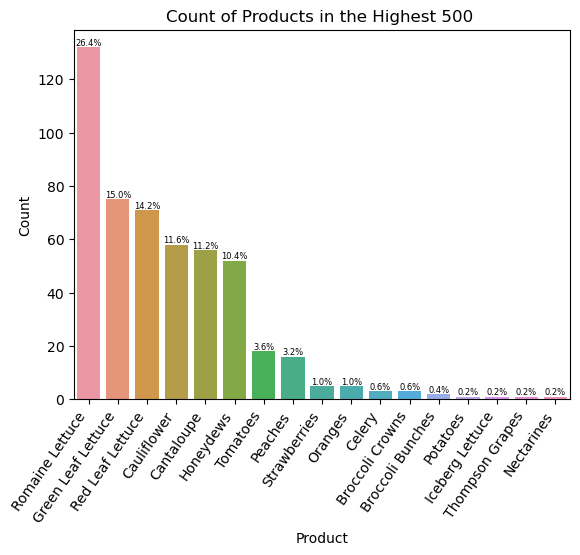

In [36]:
# Let's determine the product breakdown of these top 500 items

top_500_spreads_prod_dist = top_500_spreads.groupby('product_name').size().sort_values(ascending=False)

ax = sns.barplot(x=top_500_spreads_prod_dist.index, y=top_500_spreads_prod_dist)
ax.bar_label(ax.containers[0], labels= [f"{x/5}%" for x in top_500_spreads_prod_dist], fontsize=6)
plt.ylabel('Count')
plt.xlabel('Product')
plt.title('Count of Products in the Highest 500 ')
ax.set_xticklabels(top_500_spreads_prod_dist.index, rotation=55, ha='right')
plt.show()

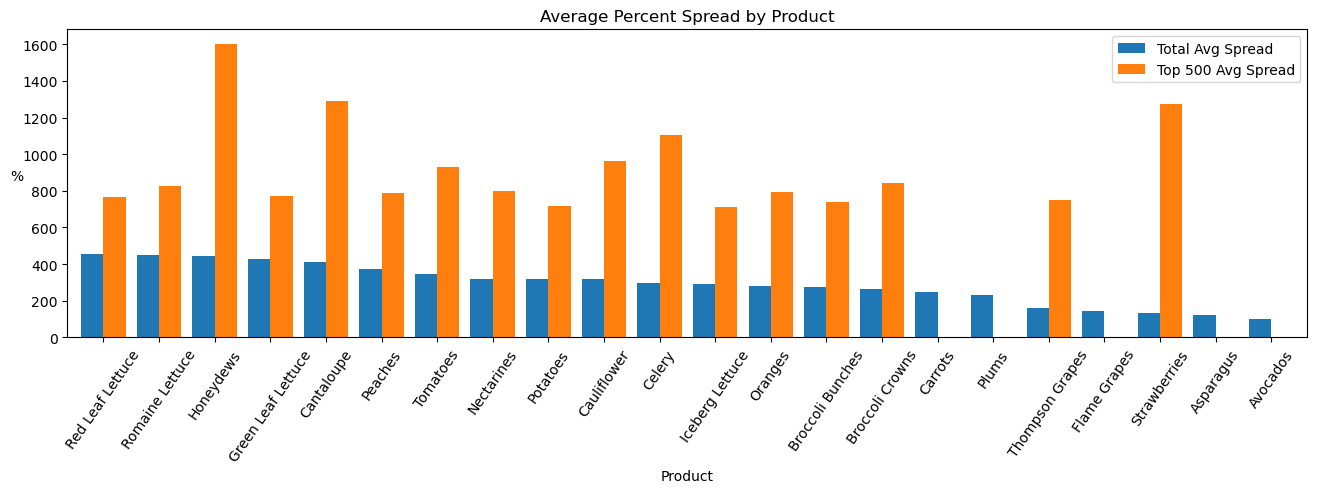

In [38]:
# Lettuces are the most frequent but which generated the highest average

# df for average 'avg_spread' of top 500
top_500_spreads_avg = top_500_spreads.groupby('product_name').mean()['avg_spread'].sort_values(ascending=False)
top_500_spreads_avg = top_500_spreads_avg.rename('Top 500 Avg Spread')

# df for average 'avg_spread' of all data
df_spreads_avg = df.groupby('product_name').mean()['avg_spread'].sort_values(ascending=False)
df_spreads_avg = df_spreads_avg.rename('Total Avg Spread')

# Bar plot
pd.concat([df_spreads_avg, top_500_spreads_avg], axis=1).plot(kind='bar', figsize=(16,4), width=.8)
plt.legend(loc='upper right')
plt.ylabel('%', rotation=0)
plt.xlabel('Product')
plt.title('Average Percent Spread by Product')
plt.tick_params(axis='x', rotation=55)
plt.show()

## Using Functions for Further Analysis
The graph above shows us that different types of lettuces carry the largest spread across all cities in our entire dataset. When we look at the top 500 highest avg_spreads we see that the trend does not hold. Rather, honeydews (and cantaloupes) and Strawberries have extremely high average spreads amongst the top 500.

The gen_product_timeseries() function defined below can be used to analyze trends in price and spread by product over time. Let's use it on honeydews and strawberries to see if we can determine why the spikes exist.

In [40]:
# Build a function that will generate timeseries of product prices and spreads for each city over time

# If the price var is False the spread data will be displayed
def gen_product_timeseries(product='Carrots', start_year=2000, end_year=2019, price=True):
    # Set string variable based on price bool variable
    if price:
        y_append = 'price'
        y_unit = '$'
        farm_replace = 'farm'
    else:
        y_append = 'spread'
        y_unit = '%'
        farm_replace = 'avg'
    
    # Create figure and axes for timeseries
    fig, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(16,12))
    fig.suptitle(f"{product} {y_append.capitalize()} ({y_unit}) from {start_year} to {end_year}", fontsize=30)
    
    # Create df for plot
    product_df = df[(df['date'].dt.year >= start_year) & (df['date'].dt.year <= end_year) & (df['product_name'] == product)]
    
    # Set color palette
    colors = sns.color_palette(n_colors=5)
    
    # Create the 'farm_price' plot at the to
        
    sns.lineplot(ax=ax[0], x='date', y=f'{farm_replace}_{y_append}', data=product_df, c=colors[0])
    ax[0].set_ylabel(f'{farm_replace.capitalize()} {y_append.capitalize()}', rotation=0, labelpad=50, fontsize=15)
    ax[0].tick_params(labelbottom=True)
    ax[0].grid()
    
    # Cities list
    cities = ['atl', 'chi', 'la', 'ny']

    for city in cities:
        axis=ax[cities.index(city)+1]
        sns.lineplot(ax=axis,x='date', y=f'{city}_{y_append}', data=product_df, c=colors[cities.index(city) + 1])
        axis.set_ylabel(f'{city.upper()} {y_append.capitalize()}', rotation=0, labelpad=50, fontsize=15)
        axis.tick_params(labelbottom=True)
        axis.grid()
    
    plt.show()

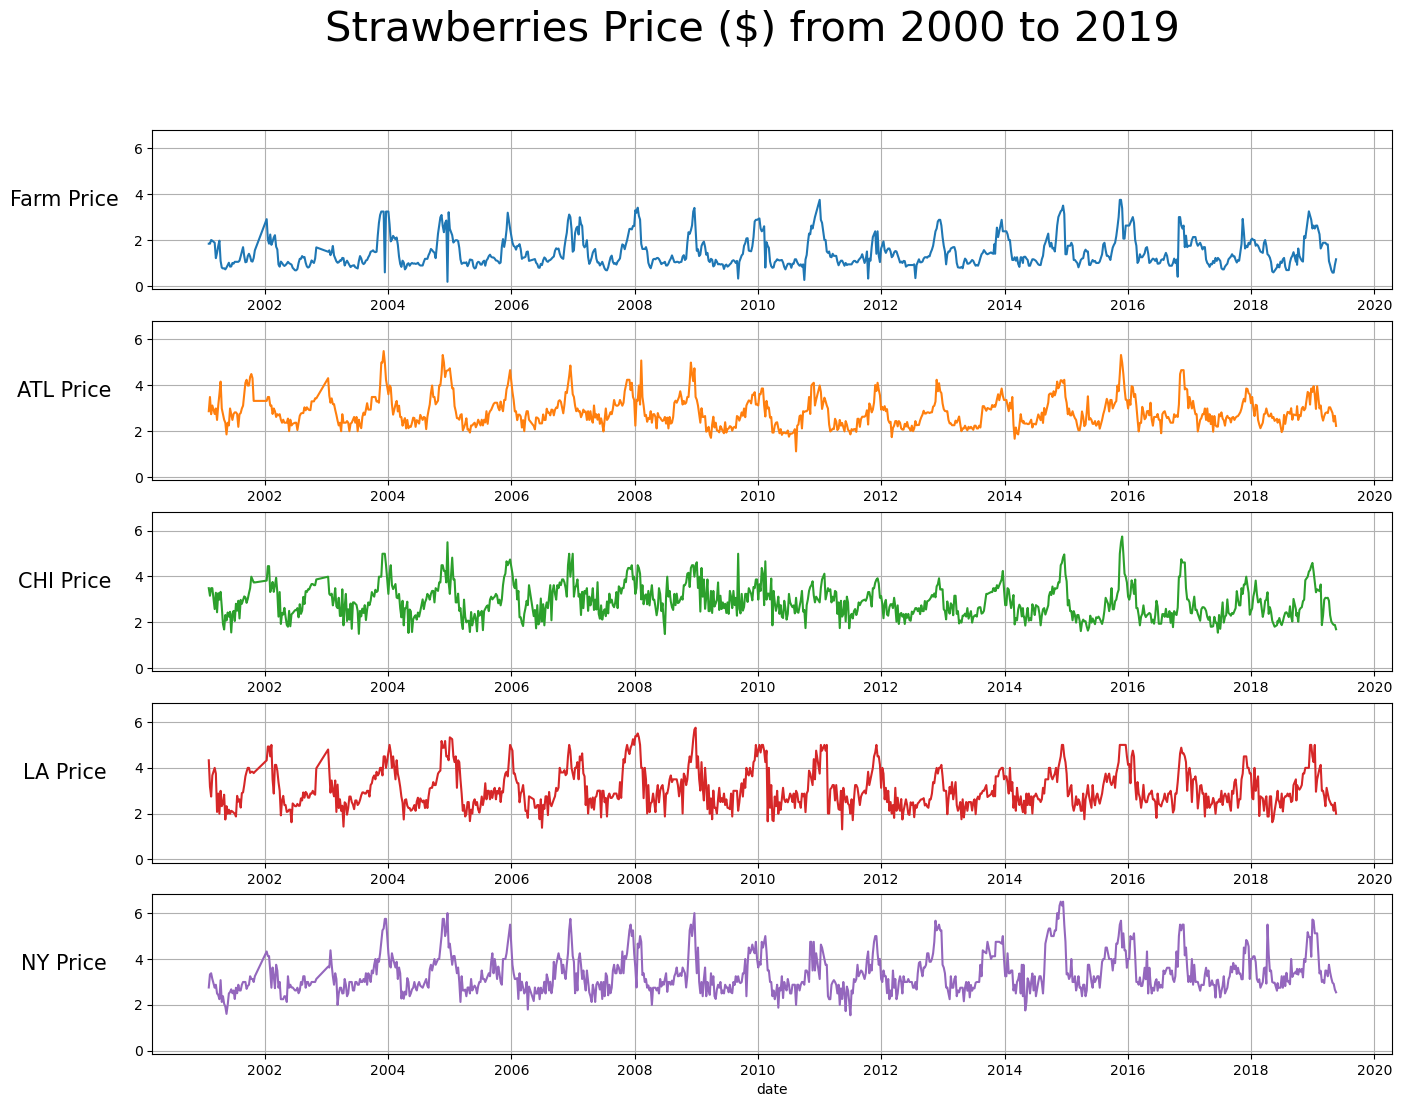

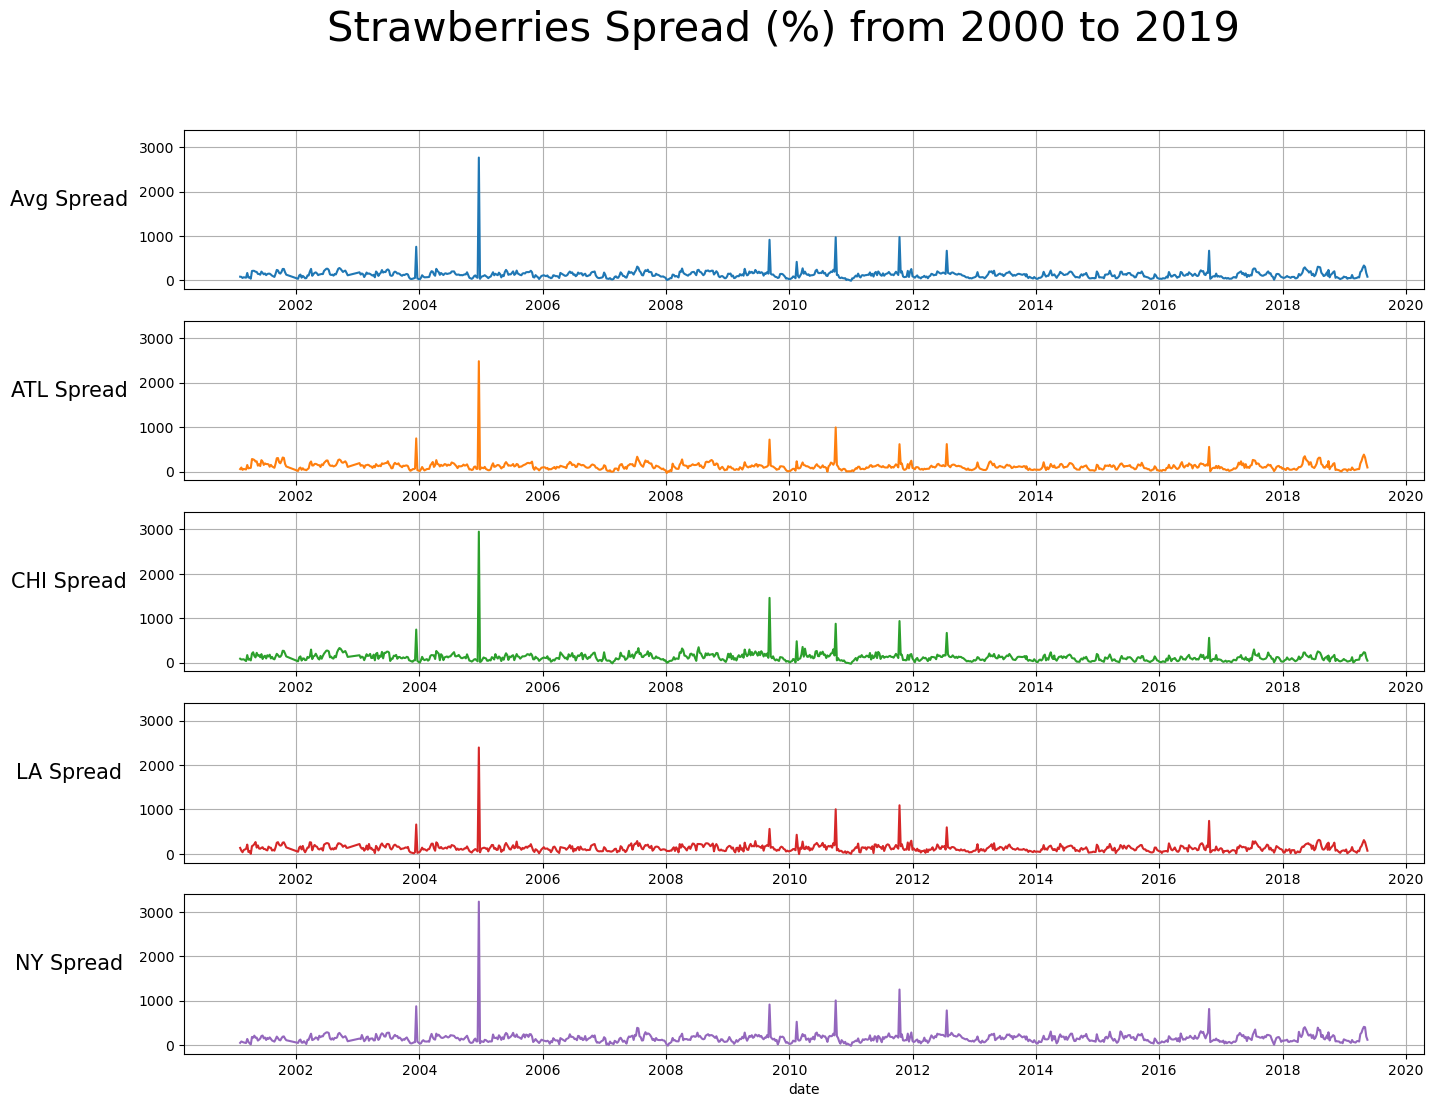

In [41]:
gen_product_timeseries('Strawberries')
gen_product_timeseries('Strawberries', start_year=2000, end_year=2019, price=False)

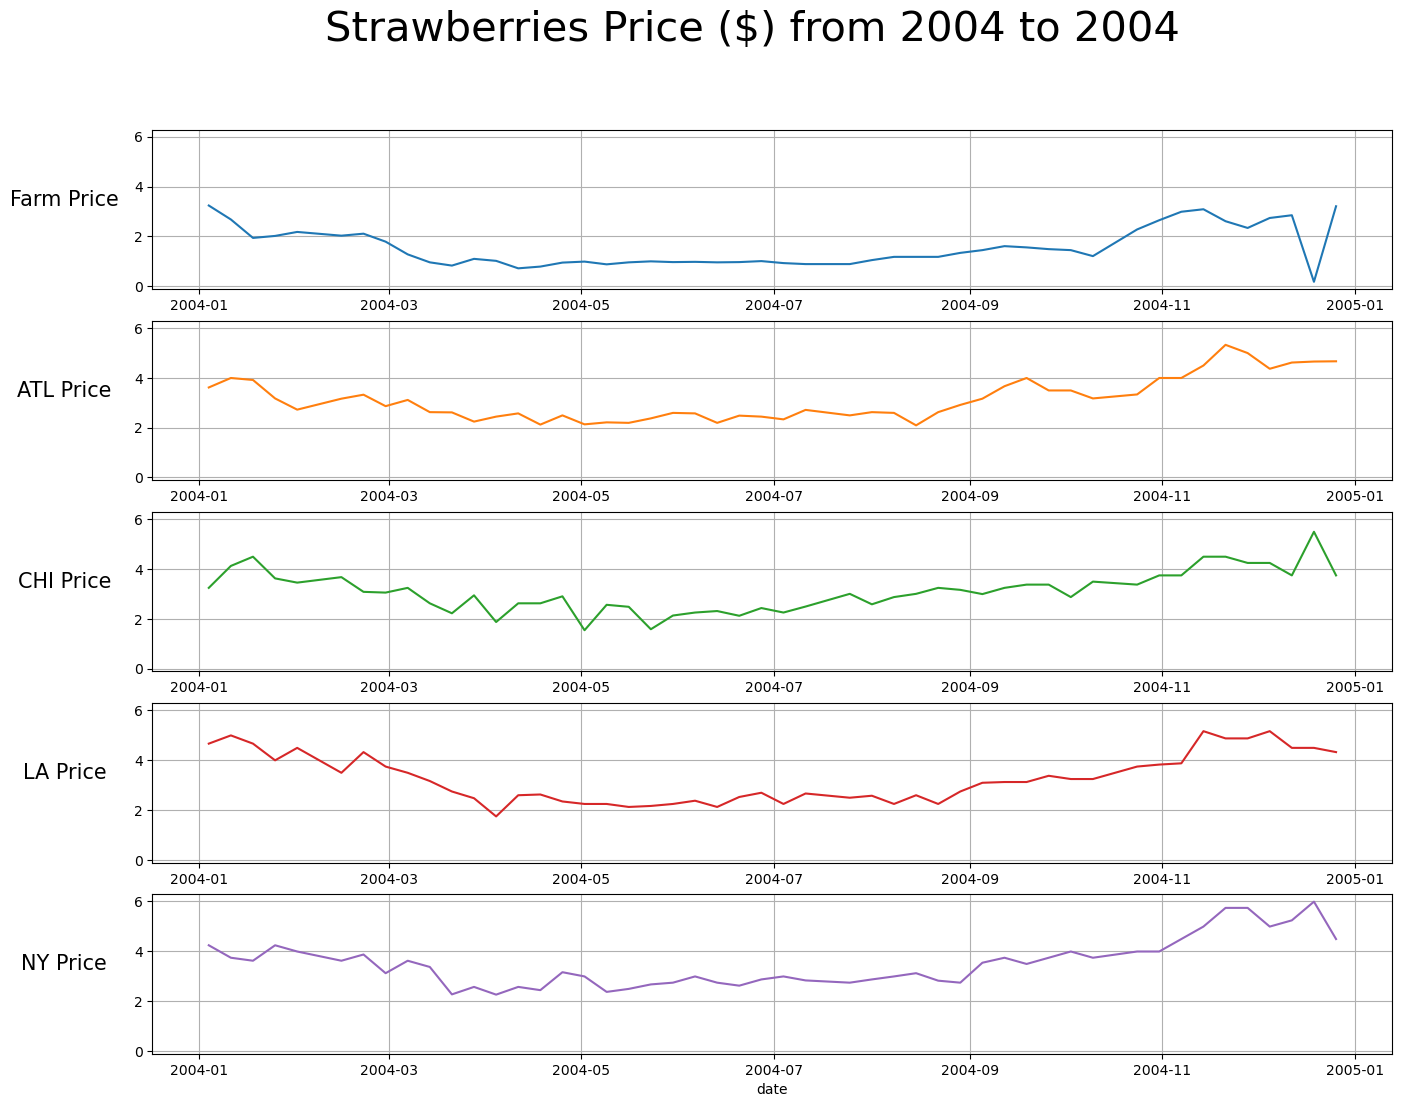

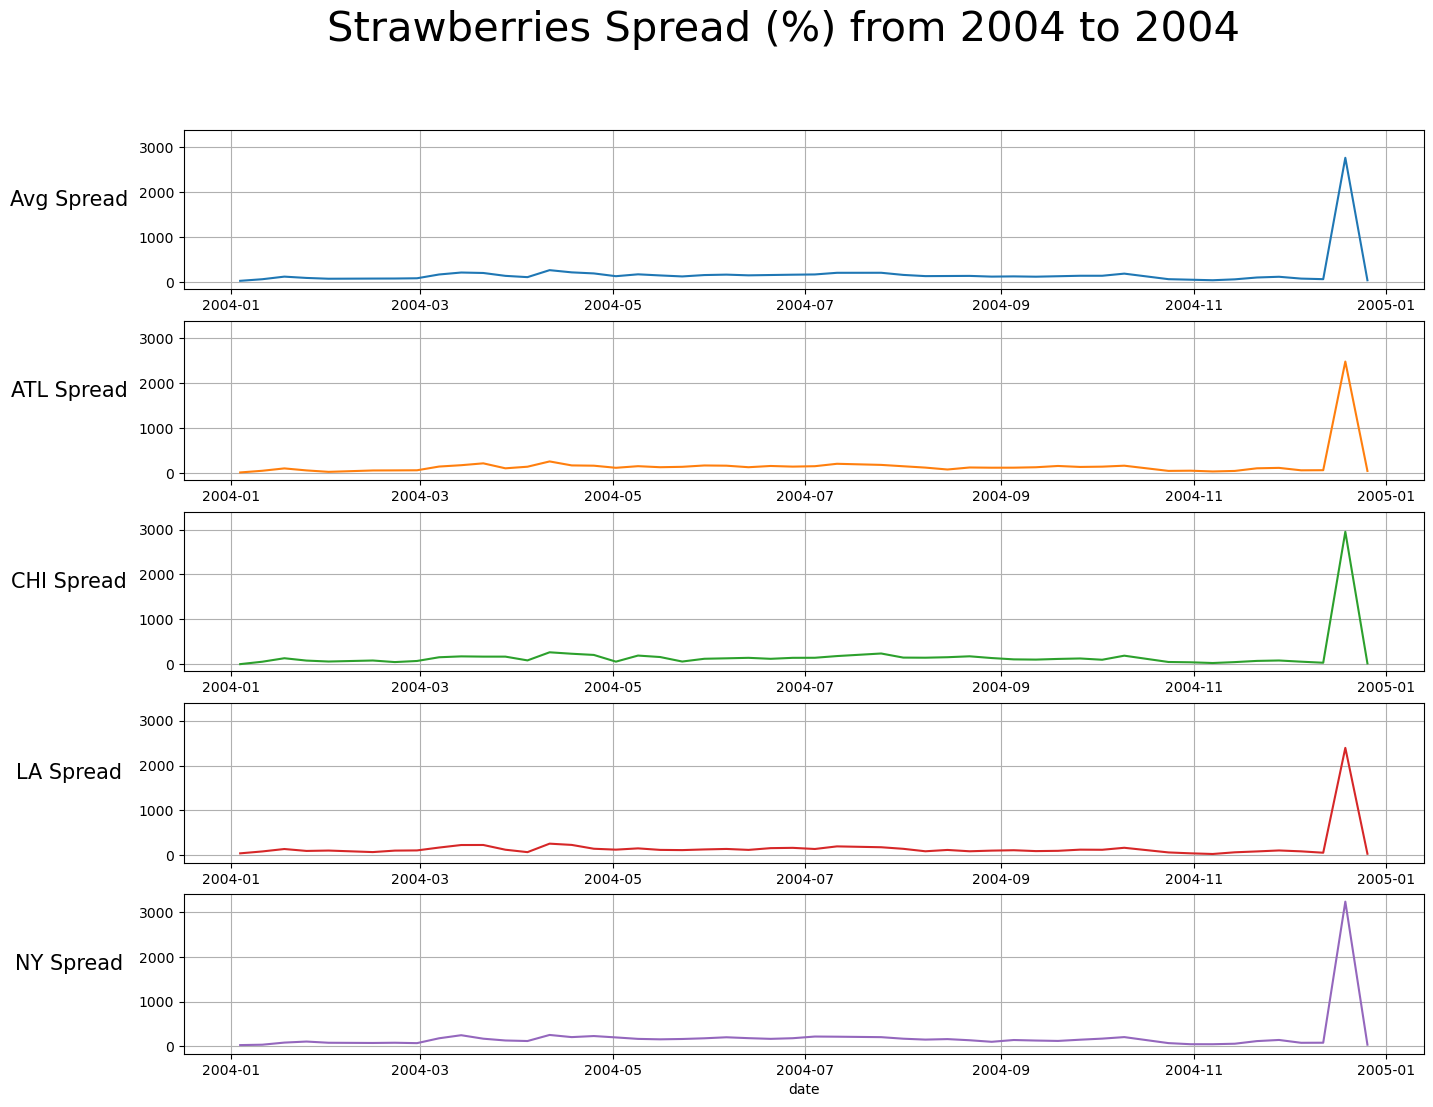

In [47]:
# Prices are very cyclical and across the board
# We see a big spike in spread betwee 2004 and 2006 so lets take a closer look
gen_product_timeseries("Strawberries", 2004, 2004)
gen_product_timeseries("Strawberries", 2004, 2004, price=False)

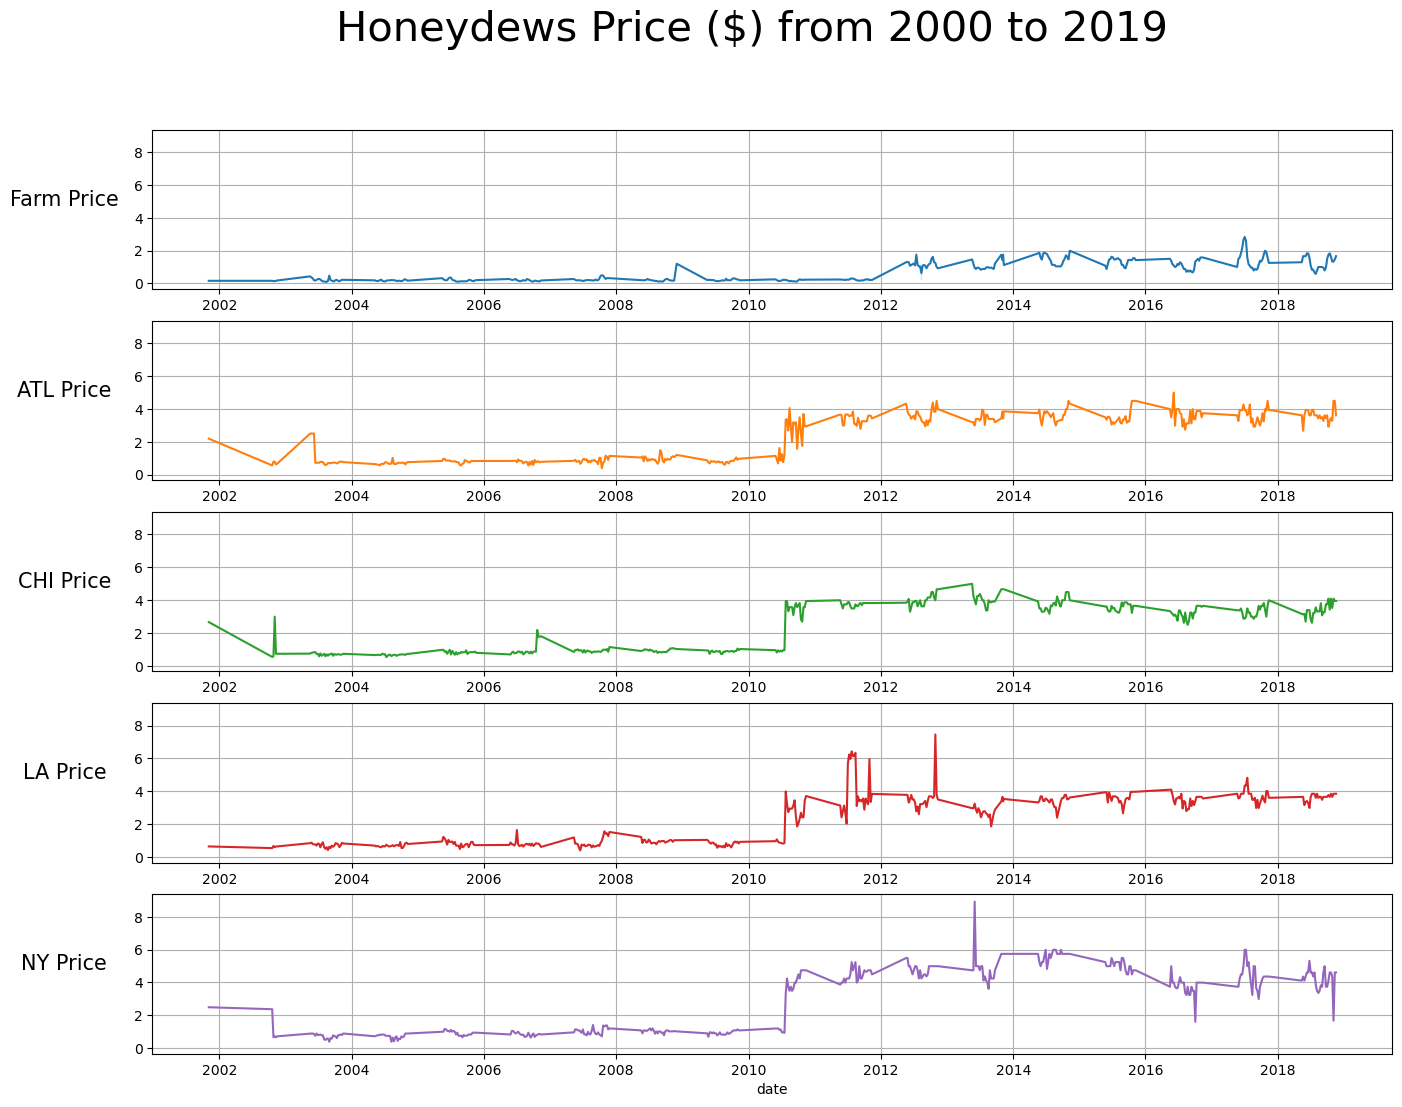

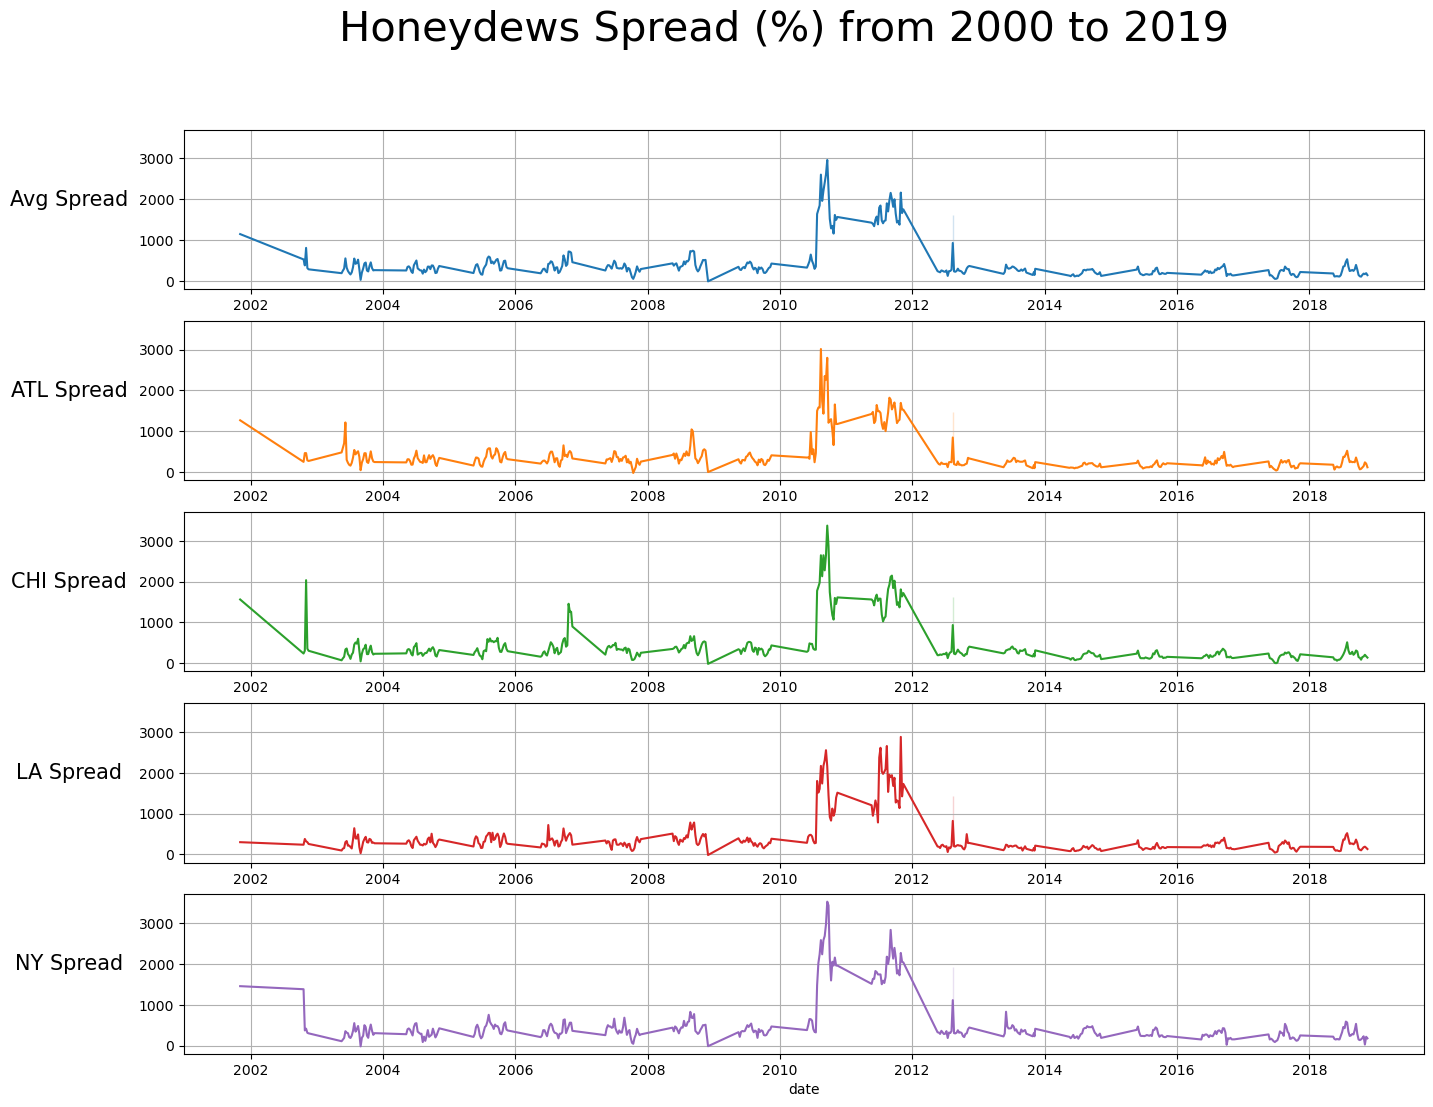

In [43]:
gen_product_timeseries('Honeydews')
gen_product_timeseries('Honeydews', price=False)

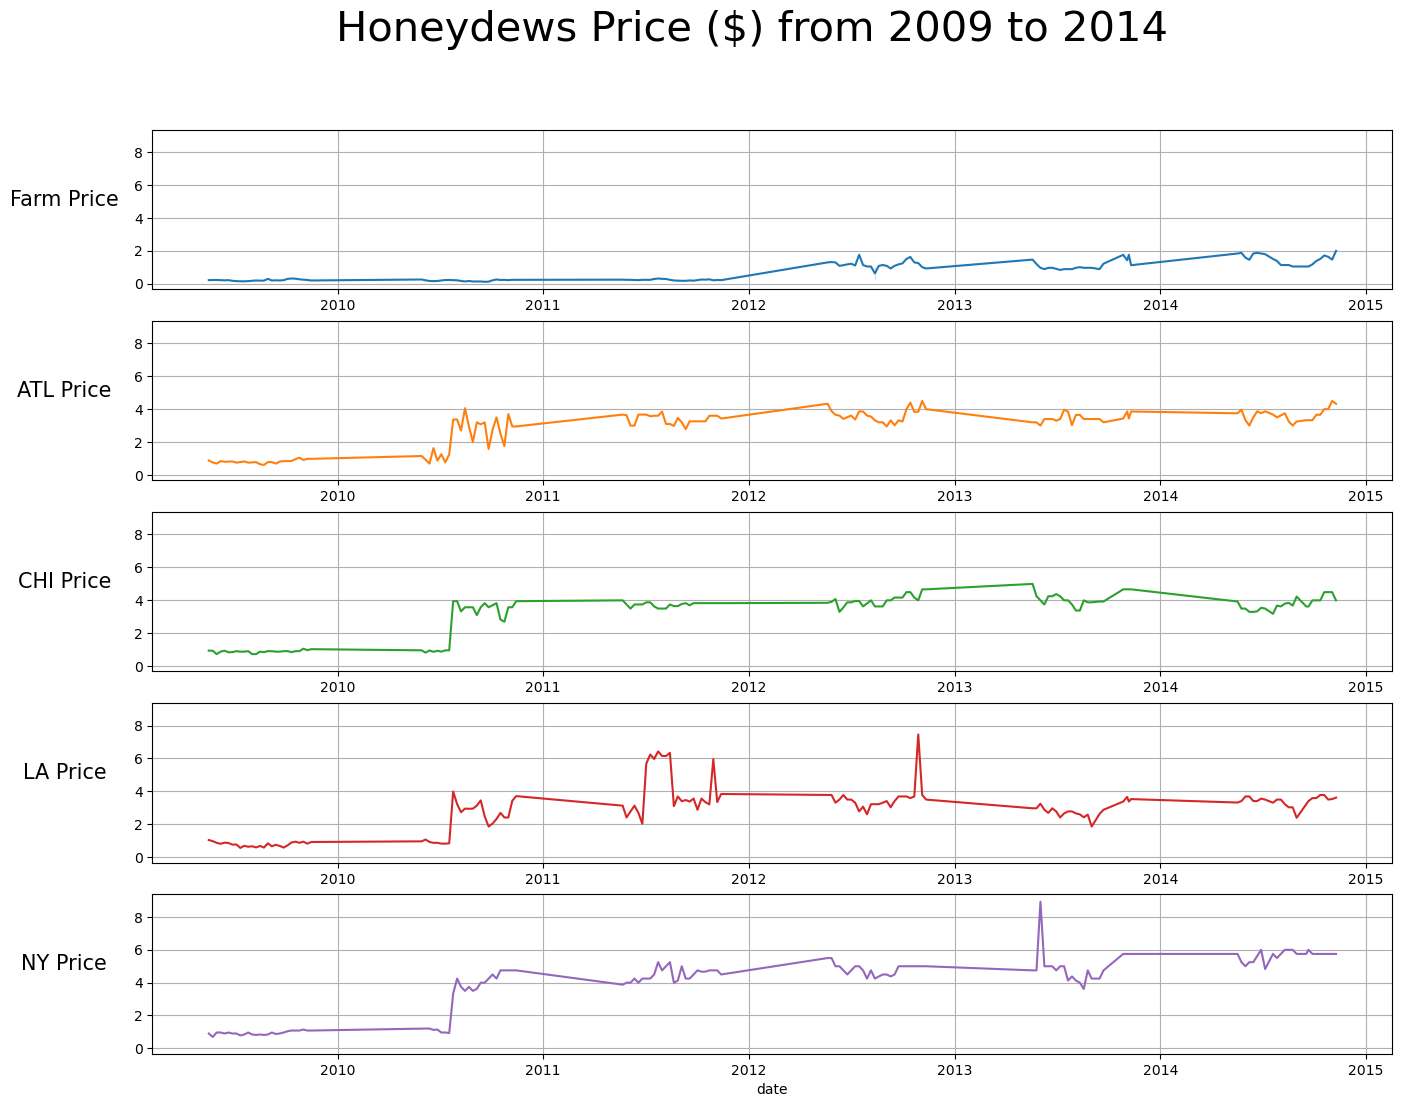

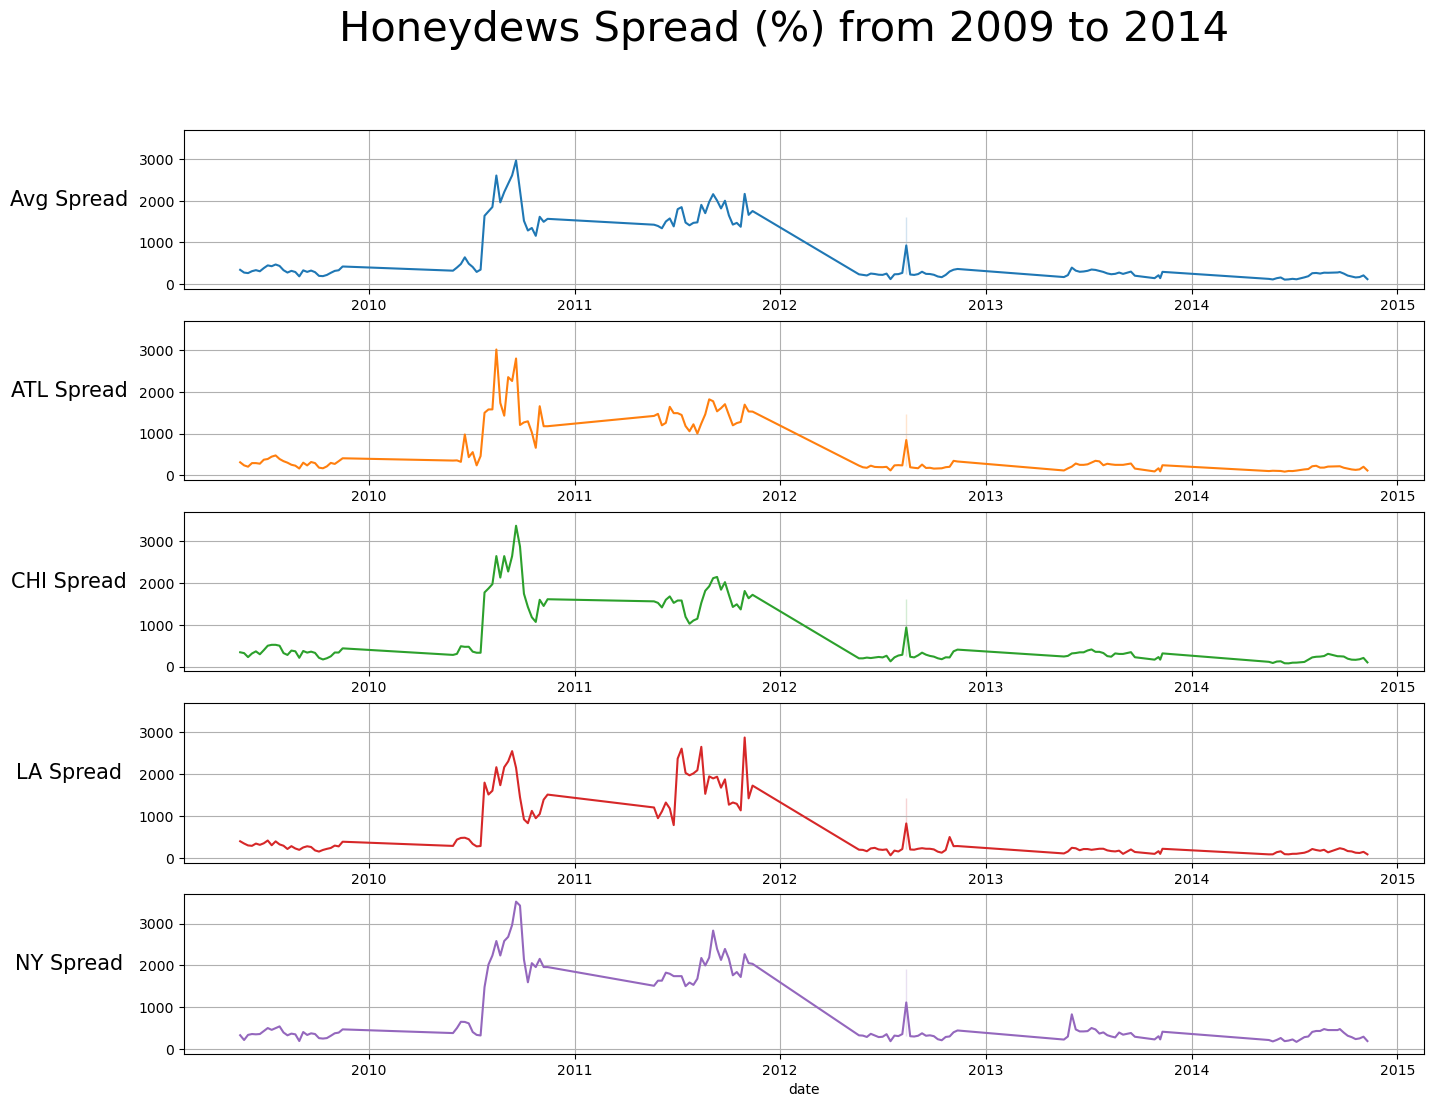

In [45]:
# Prices and spreads started moving around 2010 so lets take a closer look at that time period
gen_product_timeseries(product, 2009, 2014)
gen_product_timeseries(product, 2009, 2014, price=False)

### Strawberries
Strawberries show an extremly cyclical price structure both at the farm and retail levels: cheap during the spring and fall and tripling in price during the winter and summer. Because of this, the spread stays fairly constant. 

We did note that farm prices dropped to near \\$0.00 at the end of 2004, but retail prices stayed put and this generated spreads approaching 3000\% in all markets. The spike was shortlived as farm prices stabilized by the beginning of 2005.

### Honeydews
Honeydews showed unusual behavior in 2010 when retail prices in all markets shot while farm prices remained stable. Retail price and spread increases where uniform across all markets. Between 2010 and 2012, spreads were extremely high but farm prices began to increase in 2013 as retail prices stayed the same and spreads began to even out.

These trends and events could be explained by farm surpluses, policy or cost changes for distributors, orchanges in consumer demands.

## Ineferential Statistics: Hypothesis Testing
Finally, we will create a function to compare average prices of different products and markets to determine if average prices are different with statistical certainty.

### Method
We will use a paired T-Test (our data are dependent variables) to compare averages. Below are the functions parameters:
<ul>
    <li>data: dataframe (Required).</li>
    <li>city_1: 'atl','chi','la', or 'ny'</li>
    <li>city_2: 'atl','chi','la', or 'ny' (different than city_1)</li>
    <li>product: any product from the above df</li>
    <li>alt: 'less', 'greater', 'two-sided' (default). 'less' and 'greater' represent one-sided tests where the alternative hypothesis states that city_1's average is 'less' or 'greater' than city_2's. With 'two-sided' the alternative is that the averages are not the same.</li>
    <li>plot: True or False (default). If True a scatter plot of the data will be rendered.</li>
</ul>

In [60]:
# Paired T-test to determine if prices between cities are materialy different
import scipy.stats as stats

def paired_ttest_city(data, city_1='la', city_2='ny', product=None, alt='two-sided', plot=False):
    
    # Determine if filtering by a product and create temp_df
    temp_df = data[['product_name', f"{city_1.lower()}_price", f"{city_2.lower()}_price"]]
    if product is not None:
        product = product.capitalize()
        temp_df = temp_df[temp_df['product_name'] == product]
        
    else:
        product='All products'
    
    # Rename columns to make code more readable
    temp_df = temp_df.rename(columns={
        f"{city_1.lower()}_price":city_1,
        f"{city_2.lower()}_price":city_2
    })
    
    # Create scatter plot of selected data if plot=True
    if plot:
        sns.scatterplot(data=temp_df, x=city_1, y=city_2, hue='product_name')
        plt.title(f"{city_1.upper()} vs. {city_2.upper()} Price ($)")
        plt.xlabel(city_1.upper())
        plt.ylabel(city_2.upper())
        plt.legend(title='Product', ncols=2, bbox_to_anchor=(1,1))
        plt.show()
    
    # Run T-Test
    t_stat, p_value = stats.ttest_rel(temp_df[city_1], temp_df[city_2], alternative=alt)
    
    print(f"Paired T-Test for {city_1.upper()} and {city_2.upper()} Prices ({product})")
    print(f"Alternative: {alt}")
    print("-"*50)
    if alt=='two-sided':
        print("Null Hypothesis: Average prices in the two cities are equal")
        print("Alternative Hypothesis: Average prices in the two cities are not equal")
    elif alt=='less':
        print(f"Null Hypothesis: {city_1.upper()} has greater or equal average prices than {city_2.upper()}")
        print(f"Alternative Hypothesis: {city_1.upper()} has lower average prices than {city_2.upper()}")
    else:
        print(f"Null Hypothesis: {city_1.upper()} has lower or equal average prices than {city_2.upper()}")
        print(f"Alternative Hypothesis: {city_1.upper()} has greater average prices than {city_2.upper()}")  
    print("-"*50)
    print("DATA")
    print(f"{city_1.upper()} Mean: ${round(temp_df[city_1].mean(), 2)}")
    print(f"{city_1.upper()} Standard Deviation: ${round(temp_df[city_1].std(), 2)}")
    print(f"{city_2.upper()} Mean: ${round(temp_df[city_2].mean(), 2)}")
    print(f"{city_2.upper()} Standard Deviation: ${round(temp_df[city_2].std(), 2)}")
    print("-"*50)
    print("RESULTS")
    print("Test Statistic: {:0.2f}".format(t_stat))
    print("P-Value: {:0.2f}".format(p_value))
    print("-"*50)
    print("INTERPRETATION")
    if p_value >= 0.05:
        print("Not enough statistical evidence to reject the null hypothesis.")
    else:
        print("There is statistical evidence to reject the null hypothesis and accept the alternative hypothesis.")

In [61]:
paired_ttest_city(df, 'chi', 'ny', alt='less', plot=False)

Paired T-Test for CHI and NY Prices (All products)
Alternative: less
--------------------------------------------------
Null Hypothesis: CHI has greater or equal average prices than NY
Alternative Hypothesis: CHI has lower average prices than NY
--------------------------------------------------
DATA
CHI Mean: $1.82
CHI Standard Deviation: $0.85
NY Mean: $2.06
NY Standard Deviation: $1.05
--------------------------------------------------
RESULTS
Test Statistic: -54.78
P-Value: 0.00
--------------------------------------------------
INTERPRETATION
There is statistical evidence to reject the null hypothesis and accept the alternative hypothesis.
